## Show function

In [3]:
%matplotlib inline

In [2]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D as p3
from matplotlib.animation import FuncAnimation
import IPython

In [4]:
def show3d(states, name):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 초기 상태 플로팅
    sc = ax.scatter(0,0,0, color='red', s=500)
    ax.text(0,0,0, 'start', ha='center', va='center')
    ax.text(3,3,3, 'end', ha='center', va='center')

    # 그리드 레이블 설정
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    # Adding grid lines to the plot
    ax.set_xticks(np.arange(-.5, 4, 1))
    ax.set_yticks(np.arange(-.5, 4, 1))
    ax.set_zticks(np.arange(-.5, 4, 1))
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)

    def update(t):
        sc._offsets3d = ([states[t][0]], [states[t][1]], [states[t][2]])
    ani = FuncAnimation(fig, update, frames=len(states))

    display(IPython.display.HTML(ani.to_jshtml()))

    ani.save(name, writer='imagemagick')

MovieWriter imagemagick unavailable; using Pillow instead.


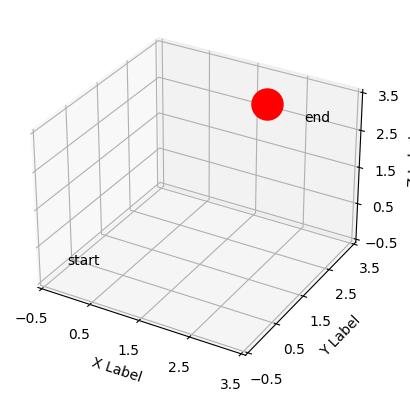

In [233]:
show3d([[0,0,0], [0,0,1], [0,0,0], [0,0,1], [0,0,0], [2,3,3]], "sample_plot.gif")

## Env 구현

In [5]:
class GridWorld:
    def __init__(self):
        self.reset()
        self.state_space = gym.spaces.MultiDiscrete([4,4,4])
        self.action_space = gym.spaces.Discrete(6) 
        self._action_to_direction = { 
            0 : np.array([1, 0, 0]), # x+ 
            1 : np.array([0, 1, 0]), # y+ 
            2 : np.array([0, 0, 1]), # x+ 
            3 : np.array([-1, 0, 0]), # y+
            4 : np.array([0, -1, 0]), # x+ 
            5 : np.array([0, 0, -1]), # y+
        }
    def reset(self):
        self.agent_action = None 
        self.agent_state = np.array([0,0,0])        
        return self.agent_state 
    def step(self,action):
        direction = self._action_to_direction[action]
        self.agent_state = self.agent_state + direction
        if self.agent_state not in self.state_space: # 4x4 그리드 밖에 있는 경우
            reward = -10 
            terminated = True
            self.agent_state = self.agent_state -1/2 * direction
        elif np.array_equal(self.agent_state, np.array([3,3,3])): # 목표지점에 도달할 경우 
            reward = 100 
            terminated = True
        else: 
            reward = -1 
            terminated = False         
        return self.agent_state, reward, terminated

In [236]:
env = GridWorld()

In [237]:
states = [] 
state = env.reset()
states.append(state) 
for t in range(50):
    action = env.action_space.sample() 
    state,reward,terminated = env.step(action)
    states.append(state) 
    if terminated: break 

MovieWriter imagemagick unavailable; using Pillow instead.


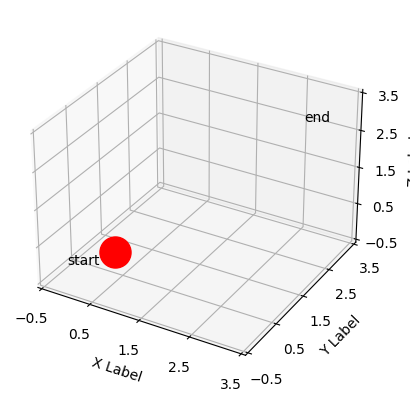

In [238]:
show3d(states, "random_step.gif")

## Agent

In [6]:
class Agent1:
    def __init__(self,env):
        self.action_space = env.action_space
        self.state_spcae = env.state_space 
        self.n_experiences = 0 
        self.n_episodes = 0 
        self.score = 0 
        
        # episode-wise info 
        self.scores = [] 
        self.playtimes = []

        # time-wise info
        self.current_state = None 
        self.action = None 
        self.reward = None 
        self.next_state = None         
        self.terminated = None 

        # replay_buffer 
        self.actions = []
        self.current_states = [] 
        self.rewards = []
        self.next_states = [] 
        self.terminations = [] 

    def act(self):
        self.action = self.action_space.sample() 

    def save_experience(self):
        self.actions.append(self.action) 
        self.current_states.append(self.current_state)
        self.rewards.append(self.reward)
        self.next_states.append(self.next_state)
        self.terminations.append(self.terminated) 
        self.n_experiences += 1 
        self.score = self.score + self.reward 
        
    def learn(self):
        pass 

In [7]:
class Agent2(Agent1):
    def __init__(self,env):
        super().__init__(env)
        self.q = np.zeros([4,4,4,6]) 
    def learn(self):
        x,y,z = self.current_state
        xx,yy,zz = self.next_state
        a = self.action 
        q_estimated = self.q[x,y,z,a] 
        if self.terminated:
            q_realistic = self.reward
        else:
            q_future = self.q[xx,yy,zz,:].max()
            q_realistic = self.reward + 0.99 * q_future
        diff = q_realistic - q_estimated 
        self.q[x,y,z,a] = q_estimated + 0.05 * diff 
    def act(self):
        if self.n_experiences < 3000: 
            self.action = self.action_space.sample() 
        else:
            x,y,z = self.current_state 
            self.action = self.q[x,y,z,:].argmax()

In [8]:
env = GridWorld() 
agent = Agent2(env) 
for _ in range(2000):
    ## 본질적인 코드 
    agent.current_state = env.reset()
    agent.terminated = False 
    agent.score = 0 
    for t in range(50):
        # step1: agent >> env 
        agent.act() 
        env.agent_action = agent.action  
        # step2: agent << env 
        agent.next_state, agent.reward, agent.terminated = env.step(env.agent_action)
        agent.save_experience() 
        # step3: learn 
        agent.learn()
        # step4: state update 
        agent.current_state = agent.next_state 
        # step5: 
        if agent.terminated: break 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t+1)
    agent.n_episodes = agent.n_episodes + 1 
    ## 덜 본질적인 코드 
    if (agent.n_episodes % 100) ==0:
        print(
            f"Epsiode: {agent.n_episodes} \t"
            f"Score: {np.mean(agent.scores[-100:])} \t"
            f"Playtime: {np.mean(agent.playtimes[-100:])}"
        )   

Epsiode: 100 	Score: -11.38 	Playtime: 2.38
Epsiode: 200 	Score: -12.32 	Playtime: 3.32
Epsiode: 300 	Score: -12.04 	Playtime: 3.04
Epsiode: 400 	Score: -11.45 	Playtime: 2.45
Epsiode: 500 	Score: -12.26 	Playtime: 3.26
Epsiode: 600 	Score: -13.07 	Playtime: 4.07
Epsiode: 700 	Score: -12.45 	Playtime: 3.45
Epsiode: 800 	Score: -11.85 	Playtime: 2.85
Epsiode: 900 	Score: -12.25 	Playtime: 3.25
Epsiode: 1000 	Score: 4.29 	Playtime: 8.71
Epsiode: 1100 	Score: 86.22 	Playtime: 12.58
Epsiode: 1200 	Score: 91.82 	Playtime: 9.18
Epsiode: 1300 	Score: 92.0 	Playtime: 9.0
Epsiode: 1400 	Score: 92.0 	Playtime: 9.0
Epsiode: 1500 	Score: 92.0 	Playtime: 9.0
Epsiode: 1600 	Score: 92.0 	Playtime: 9.0
Epsiode: 1700 	Score: 92.0 	Playtime: 9.0
Epsiode: 1800 	Score: 92.0 	Playtime: 9.0
Epsiode: 1900 	Score: 92.0 	Playtime: 9.0
Epsiode: 2000 	Score: 92.0 	Playtime: 9.0


MovieWriter imagemagick unavailable; using Pillow instead.


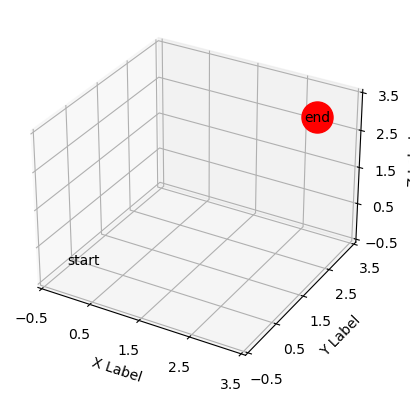

In [10]:
states = [np.array([0,0,0])] + agent.next_states[-agent.playtimes[-1]:] 
show3d(states, "greedy.gif")

In [239]:
class Agent3(Agent2):
    def __init__(self,env):
        super().__init__(env)
        self.eps = 0 
    def act(self):
        if np.random.rand() < self.eps:
            self.action = self.action_space.sample() 
        else:
            x,y,z = self.current_state 
            self.action = self.q[x,y,z,:].argmax()

In [240]:
env = GridWorld() 
agent = Agent3(env) 
agent.eps = 1
for _ in range(5000):
    ## 본질적인 코드 
    agent.current_state = env.reset()
    agent.terminated = False 
    agent.score = 0 
    for t in range(50):
        # step1: agent >> env 
        agent.act() 
        env.agent_action = agent.action  
        # step2: agent << env 
        agent.next_state, agent.reward, agent.terminated = env.step(env.agent_action)
        agent.save_experience() 
        # step3: learn 
        agent.learn()
        # step4: state update 
        agent.current_state = agent.next_state 
        # step5: 
        if agent.terminated: break 
    agent.scores.append(agent.score) 
    agent.playtimes.append(t+1)
    agent.n_episodes = agent.n_episodes + 1
    agent.eps = agent.eps * 0.999
    ## 덜 본질적인 코드 
    if (agent.n_episodes % 200) ==0:
        print(
            f"Epsiode: {agent.n_episodes} \t"
            f"Score: {np.mean(agent.scores[-100:])} \t"
            f"Playtime: {np.mean(agent.playtimes[-100:])}\t"
            f"Epsilon: {agent.eps : .2f}"
        )   

Epsiode: 200 	Score: -12.87 	Playtime: 3.87	Epsilon:  0.82
Epsiode: 400 	Score: -12.66 	Playtime: 4.76	Epsilon:  0.67
Epsiode: 600 	Score: -11.55 	Playtime: 6.95	Epsilon:  0.55
Epsiode: 800 	Score: -5.94 	Playtime: 6.93	Epsilon:  0.45
Epsiode: 1000 	Score: 6.57 	Playtime: 6.43	Epsilon:  0.37
Epsiode: 1200 	Score: 43.05 	Playtime: 8.45	Epsilon:  0.30
Epsiode: 1400 	Score: 43.16 	Playtime: 8.34	Epsilon:  0.25
Epsiode: 1600 	Score: 42.62 	Playtime: 7.78	Epsilon:  0.20
Epsiode: 1800 	Score: 56.12 	Playtime: 8.58	Epsilon:  0.17
Epsiode: 2000 	Score: 60.49 	Playtime: 8.61	Epsilon:  0.14
Epsiode: 2200 	Score: 66.95 	Playtime: 8.75	Epsilon:  0.11
Epsiode: 2400 	Score: 71.38 	Playtime: 8.72	Epsilon:  0.09
Epsiode: 2600 	Score: 71.56 	Playtime: 8.54	Epsilon:  0.07
Epsiode: 2800 	Score: 74.87 	Playtime: 8.53	Epsilon:  0.06
Epsiode: 3000 	Score: 82.1 	Playtime: 9.0	Epsilon:  0.05
Epsiode: 3200 	Score: 80.11 	Playtime: 8.79	Epsilon:  0.04
Epsiode: 3400 	Score: 81.24 	Playtime: 8.76	Epsilon:  0.03
E

MovieWriter imagemagick unavailable; using Pillow instead.


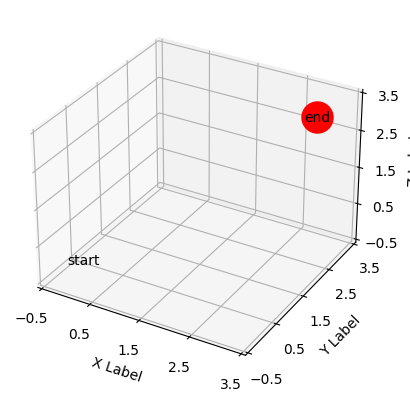

In [242]:
states = [np.array([0,0,0])] + agent.next_states[-agent.playtimes[-1]:] 
show3d(states, "epsilon-greedy.gif")